# MU4MEN01 - Introduction à l'optimisation

## Projet : Dimensionnement de stockage embarqué dans un tramway

### Objectifs du projet :

Lors de ce projet d'optimisation, nous essaierons de :
- Mettre en œuvre une démarche d’optimisation pour la conception d’un système,
- Comprendre le principe de l’alimentation électrique des tramways,
- Découvrir l’optimisation multi-critères et le concept d’optimalité au  sens de Pareto,
- Et mettre en œuvre l’algorithme génétique `NSGA-2`. 
___

### Étudiants : Jacques GUÉRIN (21112101) - William WU (21107936)
- mail 1 : jacques.guerin@etu.sorbonne-universite.fr
- mail 2 : William.Wu@etu.sorbonne-universite.fr
___

### Import des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Données initiales de notre problème

In [2]:
### Données initiales

V_s = 790           # Tension nominale (V)
R_s = 33e-3         # Résistance interne (ohms)
rho_lac = 131e-6    # Résistance linéique LAC (ohms/m)
rho_rail = 18e-6    # Résistance linéique rail (ohms/m)
M = 70_000          # Masse du train (kg)
P_bord = 35_000     # Consommation électrique à bord (W)
rendement = 0.8     # Rendement global

# 2.1 Mise en place du modèle du système

Longueur de la ligne : 1246.44348144531 m
Simulation avec une capacité de batterie de 5.0 MJ
Simulation sans batterie...
Affichage des résultats...


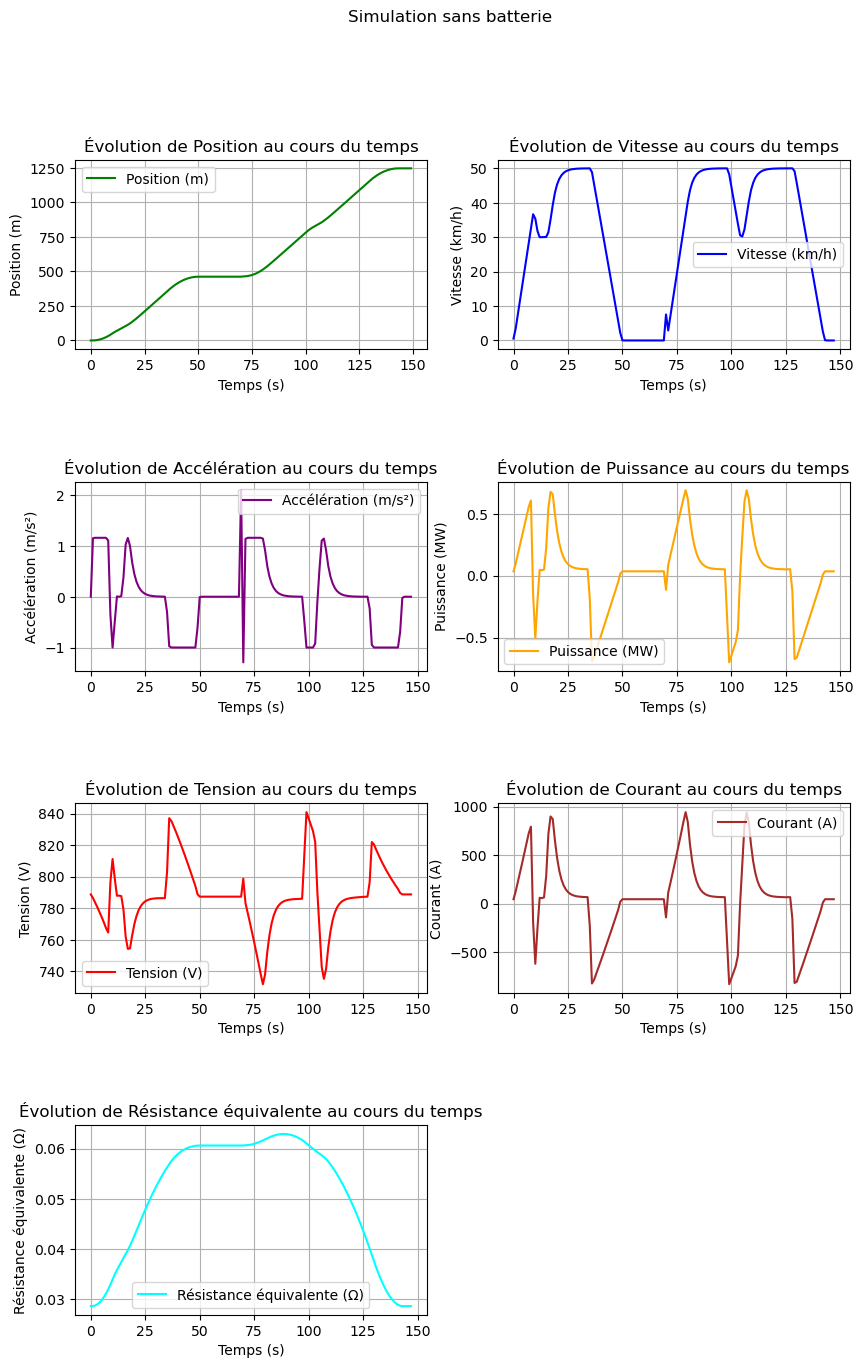

Simulation avec batterie...
Affichage des résultats...


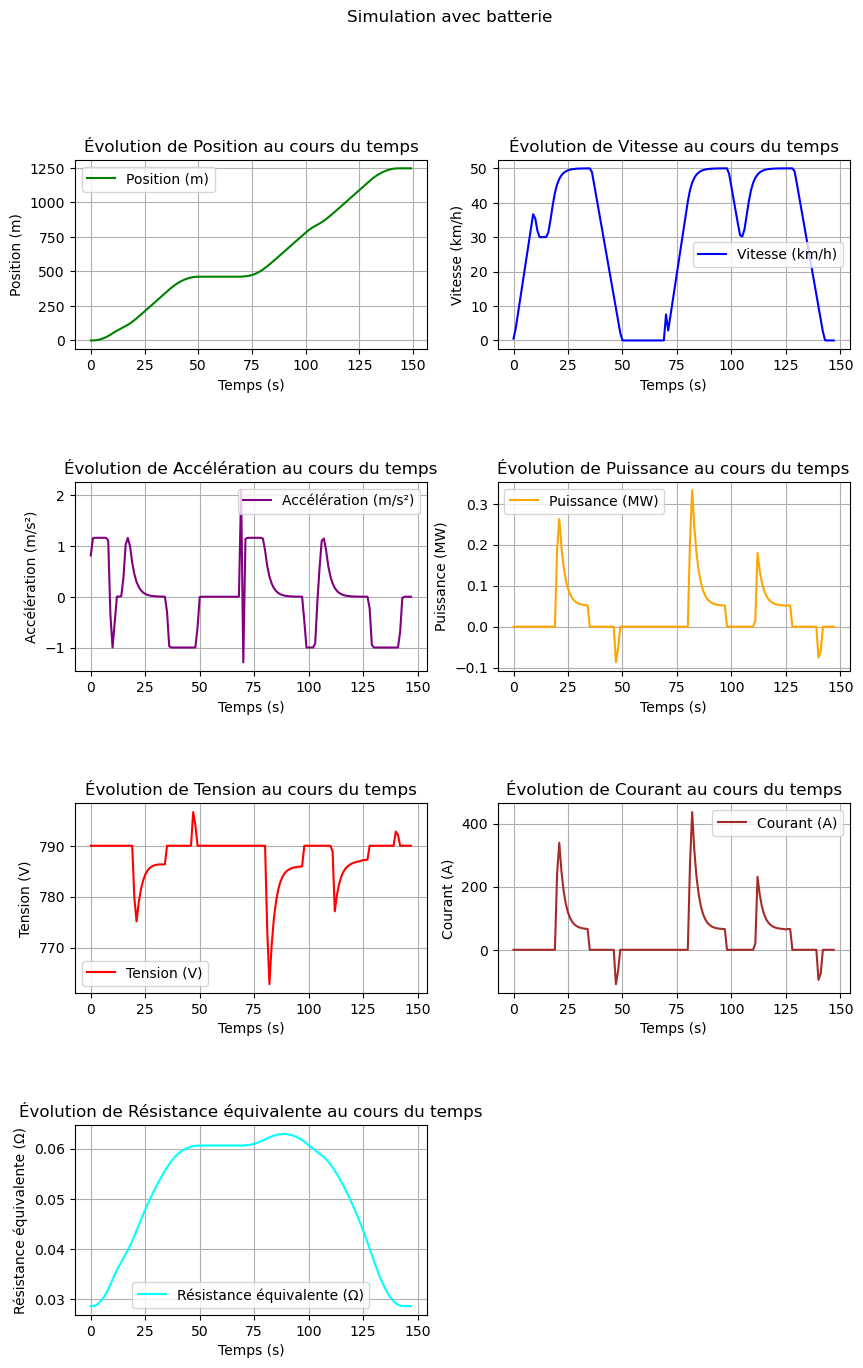

In [3]:

### Création d'une classe pour optimiser les tracés:

class Data:
    def __init__(self, temps, valeurs, nom, unite, couleur):
        """
        Initialisation de l'objet Data.

        Arguments :
        - temps (array) : Les valeurs de temps associées.
        - valeurs (array) : Les valeurs à tracer.
        - nom (str) : Le nom des données (ex. 'Vitesse', 'Position').
        - unite (str) : L'unité des données (ex. 'm/s', 'V').
        - couleur (str) : Couleur de la courbe (par défaut : "blue").
        """
        self.temps = temps
        self.valeurs = valeurs
        self.nom = nom
        self.unite = unite
        self.couleur = couleur

    def tracer(self):
        """
        Trace les données avec un titre et des étiquettes adaptés.
        """
        plt.plot(self.temps, self.valeurs, label=f"{self.nom} ({self.unite})", color=self.couleur)
        plt.xlabel("Temps (s)")
        plt.ylabel(f"{self.nom} ({self.unite})")
        plt.title(f"Évolution de {self.nom} au cours du temps")
        plt.legend()
        plt.grid()

    def afficher(self):
        """
        Affiche directement le tracé des données.
        """
        self.tracer()
        plt.show()

### Les fonctions de calcul

def calcul_resistance(distance, rho):
    '''Calcul de la résistance entre sous-station et train.'''
    return rho * distance

def puissance_mecanique(vitesse, acceleration, alpha):
    '''Calcule de la puissance mécanique nécessaire.'''
    # Coefficients de résistance
    A = 780
    A_t = 6.4
    B = 0
    B_t = 0.14
    C = 0.3634
    C_t = 0

    F_resistance = (A + A_t * M / 1_000) + (B + B_t * M / 1_000) * vitesse + (C + C_t * M / 1_000) * vitesse**2
    F_gravite = M * 9.81 * np.sin(np.radians(alpha))
    F_motrice = F_resistance + F_gravite + (M * acceleration)
    return F_motrice * vitesse

def puissance_electrique(p_mec):
    '''Calcul de la puissance électrique à partir de la mécanique.'''
    return p_mec * rendement

def tension_train(P_train, R_eq):
    '''Calcul de Tension aux bornes du train.
    Résolution de l'équation : V^2 - V*V_s + R_eq*P_train = 0.'''
    delta = V_s**2 - 4 * R_eq * P_train
    # Pour un delta négatif pas de solution
    if delta < 0:
        return None
    vitesse_1 = (V_s + np.sqrt(delta)) / 2
    vitesse_2 = (V_s - np.sqrt(delta)) / 2
    return max(vitesse_1, vitesse_2)

### Train en déplacement

def charger_donnees_train(fichier):
    """Charge les données de déplacement du train à partir d'un fichier texte.
    Arguments: 
        fichier (str): Chemin vers le fichier `marche.txt`.
    Renvoie:
        tuple (2 tableaux numpy): les temps et les positions."""
    try:
        data = np.loadtxt(fichier, delimiter='\t', dtype=float)
        temps = data[:, 0]  # Première colonne : temps
        positions = data[:, 1]  # Deuxième colonne : positions
        return temps, positions
    except Exception as e:
        print(f"Erreur lors du chargement des données : {e}")
        return None, None

def calcul_resistances(position, longueur_ligne):
    '''Calcul des résistances lorsque le train est en déplacement.'''
    distance_1 = position
    distance_2 = longueur_ligne - position
    R1 = calcul_resistance(distance_1, rho_lac + rho_rail) + R_s
    R2 = calcul_resistance(distance_2, rho_lac + rho_rail) + R_s
    return R1, R2

### Simulation sans batterie

def simulation_sans_batterie(temps, positions, longueur_ligne):
    """
    Fait la simulation du système sans batterie.
    
    Arguments :
        temps (array): Tableau des temps.
        positions (array): Tableau des positions.
        longueur_ligne (float): Longueur totale de la ligne.
    
    Retourne :
        tuple: Listes des tensions et des courants.
    """
    tensions = []
    courants = []
    puissances = []
    vitesses = []
    accelerations = []
    resistances_eq = []

    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Résistances
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1*R2) / (R1+R2)
        resistances_eq.append(R_eq)

        # Calcul de la vitesse (différence entre deux positions successives)
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]
        
        vitesse_1 = (positions[i+1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i+2] - positions[i+1]) / dt2 if dt2 != 0 else 0

        acceleration = (vitesse_2-vitesse_1) / (temps[i + 2] - temps[i + 1]) if i > 0 else 0

        # Puissance mécanique et électrique
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha = 0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Tension aux bornes du train
        V_train = tension_train(P_train, R_eq)
        if V_train is None:
            raise ValueError(f"Pas de solution pour la tension au temps {temps[i]}")

        # Stocker les résultats
        vitesses.append(vitesse_1*3.6)          # Conversion en km/h
        accelerations.append(acceleration)
        tensions.append(V_train)
        puissances.append(P_train/(10**6))      # Conversion en MW
        courants.append(P_train / V_train)

    return resistances_eq, vitesses, accelerations, tensions, puissances, courants

### Simulation avec batterie

def simulation_avec_batterie(temps, positions, longueur_ligne, capacite_batterie):
    """
    Simule le système avec batterie.

    Arguments :
        temps (array): Tableau des temps.
        positions (array): Tableau des positions.
        longueur_ligne (float): Longueur totale de la ligne.
        capacite_batterie (float): Capacité maximale de la batterie (en joules).

    Retourne :
        tuple: Listes des tensions, courants, vitesses, accélérations, puissances et résistances.
    """
    tensions = []
    courants = []
    puissances = []
    vitesses = []
    accelerations = []
    resistances_eq = []

    energie_batterie = capacite_batterie  # État initial de la batterie (plein)
    
    for i in range(len(temps) - 2):  # On boucle sur les indices des pas de temps
        # Résistances
        R1, R2 = calcul_resistances(positions[i], longueur_ligne)
        R_eq = (R1 * R2) / (R1 + R2)
        resistances_eq.append(R_eq)

        # Calcul de la vitesse (différence entre deux positions successives)
        dt1 = temps[i + 1] - temps[i]
        dt2 = temps[i + 2] - temps[i + 1]
        
        vitesse_1 = (positions[i+1] - positions[i]) / dt1 if dt1 != 0 else 0
        vitesse_2 = (positions[i+2] - positions[i+1]) / dt2 if dt2 != 0 else 0

        # Calcul de l'accélération
        acceleration = (vitesse_2 - vitesse_1) / (temps[i + 2] - temps[i + 1]) if dt2 != 0 else 0

        # Puissance mécanique et électrique
        P_mec = puissance_mecanique(vitesse_1, acceleration, alpha=0)
        P_train = puissance_electrique(P_mec) + P_bord

        # Gestion de la batterie
        if P_train > 0:  # Le train consomme de la puissance
            if energie_batterie > 0:  # Si la batterie n'est pas vide
                # Fournir de l'énergie par la batterie
                P_batt = min(energie_batterie / dt1, P_train)  # Puissance max que la batterie peut fournir
                P_train -= P_batt  # Réduction de la puissance demandée à la LAC
                energie_batterie -= P_batt * dt1  # Mise à jour de l'énergie de la batterie
        elif P_train < 0:  # Le train freine (P_train négative)
            if energie_batterie < capacite_batterie:  # Si la batterie n'est pas pleine
                # Stocker l'énergie de freinage
                P_batt = min(-P_train, (capacite_batterie - energie_batterie) / dt1)
                energie_batterie += P_batt * dt1  # Mise à jour de l'énergie stockée
                P_train += P_batt  # Réduction de l'énergie dissipée dans le rhéostat

        # Tension aux bornes du train
        V_train = tension_train(P_train, R_eq)
        if V_train is None:
            raise ValueError(f"Pas de solution pour la tension au temps {temps[i]}")

        # Stocker les résultats
        vitesses.append(vitesse_1 * 3.6)  # Conversion en km/h
        accelerations.append(acceleration)
        tensions.append(V_train)
        puissances.append(P_train / (10**6))  # Conversion en MW
        courants.append(P_train / V_train)

    return resistances_eq, vitesses, accelerations, tensions, puissances, courants

### Affichage des résultats

def plot_all(fig_name, temps, positions, vitesses, accelerations, puissances, tensions, courants, resistances_eq):
    """
    Trace tous les graphiques pour les données fournies.
    """
    plt.figure(num=fig_name, figsize=(10, 15))
    plt.suptitle(fig_name)
    plt.subplots_adjust(hspace=0.7)

    # Création des objets Data pour chaque série de données
    donnees = [
        Data(temps[:len(positions)], positions, "Position", "m", couleur="green"),
        Data(temps[:len(vitesses)], vitesses, "Vitesse", "km/h", couleur="blue"),
        Data(temps[:len(accelerations)], accelerations, "Accélération", "m/s²", couleur="purple"),
        Data(temps[:len(puissances)], puissances, "Puissance", "MW", couleur="orange"),
        Data(temps[:len(tensions)], tensions, "Tension", "V", couleur="red"),
        Data(temps[:len(courants)], courants, "Courant", "A", couleur="brown"),
        Data(temps[:len(resistances_eq)], resistances_eq, "Résistance équivalente", "Ω", couleur="cyan")
    ]

    # Boucle pour tracer chaque série de données
    for i, data in enumerate(donnees):
        plt.subplot(4, 2, i + 1)
        data.tracer()

    plt.show()

def main():
    # 1. Chargement des données
    fichier_donnees = "marche.txt"
    temps, positions = charger_donnees_train(fichier_donnees)
    
    if temps is None or positions is None:
        print("Erreur : Impossible de charger les données du fichier.")
        return

    # Limiter l'échantillonnage à 150 points
    temps = temps[:150]
    positions = positions[:150]

    # 2. Définir les paramètres de la ligne de tramway
    longueur_ligne = max(positions)  # Longueur totale de la ligne (en mètres)
    capacite_batterie = 5e6  # Capacité de la batterie (en joules, ici 5 MJ)

    print(f"Longueur de la ligne : {longueur_ligne} m")
    print(f"Simulation avec une capacité de batterie de {capacite_batterie / 1e6} MJ")

    # 3. Simulation sans batterie
    print("Simulation sans batterie...")
    try:
        resistances_eq_sb, vitesses_sb, accelerations_sb, tensions_sb, puissances_sb, courants_sb = simulation_sans_batterie(temps, positions, longueur_ligne)
    except Exception as e:
        print(f"Erreur pendant la simulation sans batterie : {e}")
        return
    
    print("Affichage des résultats...")
    plot_all("Simulation sans batterie", temps, positions, vitesses_sb, accelerations_sb, puissances_sb, tensions_sb, courants_sb, resistances_eq_sb)

    # 4. Simulation avec batterie
    print("Simulation avec batterie...")
    try:
        resistances_eq_ab, vitesses_ab, accelerations_ab, tensions_ab, puissances_ab, courants_ab = simulation_avec_batterie(temps, positions, longueur_ligne, capacite_batterie)
    except Exception as e:
        print(f"Erreur pendant la simulation avec batterie : {e}")
        return
    
    print("Affichage des résultats...")
    plot_all("Simulation avec batterie", temps, positions, vitesses_ab, accelerations_ab, puissances_ab, tensions_ab, courants_ab, resistances_eq_ab)

if __name__ == "__main__":
    main()

# 2.2 Dimensionnement du système de stockage

### Méthode de Monte-Carlo

**Objectif** : minimiser $V_{sst} - V_{train}$

Pour répondre à cet objectif nous avons pris en compte deux éléments:
- La capacité en énergie de la batterie
- Et la chute de tension maximale

Simulations de Monte-Carlo...
Solutions non dominées (Capacité de la batterie (Wh), Chute de tension maximale (V)): 
[[6.31959320e+01 8.42682542e+01]
 [6.50909243e+01 9.88989916e+00]
 [6.87879525e+01 2.19532658e+00]
 [7.93077304e+01 1.27263554e-02]
 [6.40534492e+01 1.13852864e+01]
 [7.58093374e+01 1.65287906e+00]
 [7.76832138e+01 1.51626085e+00]
 [4.39942928e+02 6.92434003e-03]
 [7.31906147e+01 1.66389292e+00]
 [6.27241089e+01 9.26226174e+01]
 [7.04589157e+01 2.04704616e+00]]
Affichage des résultats...


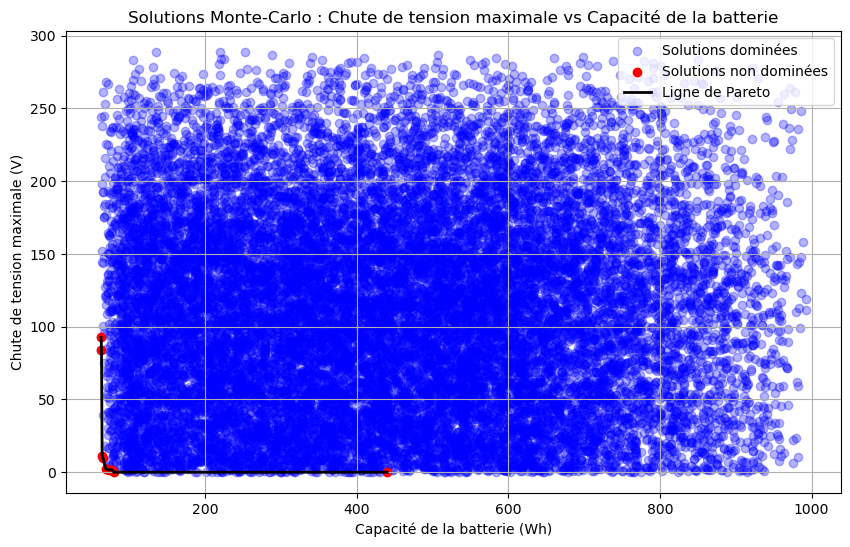

In [4]:
# Paramètres du système (ajustés pour plus de diversité)
max_battery_capacity = 1000  # Capacité maximale de la batterie en Wh
max_voltage_drop = 290       # Chute de tension maximale en volts (par rapport à la tension nominale de 500V)
n_samples = 20000            # Augmentation du nombre d'échantillons pour obtenir plus de diversité

# Fonction pour simuler la capacité de la batterie et la chute de tension
def simulate_system(battery_capacity, voltage_drop_factor):
    """Simule la capacité de la batterie et la chute de tension."""
    battery_energy = battery_capacity * np.random.uniform(0.6, 1.0)
    voltage_drop = max_voltage_drop * np.random.uniform(0.0, 1.0) * voltage_drop_factor
    return battery_energy, voltage_drop

# Fonction pour identifier les solutions non dominées
def non_dominated_sort(results):
    """Identifie les solutions non dominées."""
    n = len(results)
    is_dominated = np.zeros(n, dtype=bool)

    for i in range(n):
        for j in range(n):
            if (results[j, 0] <= results[i, 0] and results[j, 1] <= results[i, 1]) and (i != j):
                is_dominated[i] = True
                break

    return results[~is_dominated]

def main():
    # 5. Simulations de Monte-Carlo
    print("Simulations de Monte-Carlo...")
    try:
        max_battery_capacity = 1000
        max_voltage_drop = 290
        n_samples = 20000

        battery_capacities = np.random.uniform(100, max_battery_capacity, n_samples)
        voltage_drop_factors = np.random.uniform(0.5, 1.0, n_samples)

        results = []
        for i in range(n_samples):
            battery_energy, voltage_drop = simulate_system(battery_capacities[i], voltage_drop_factors[i])
            results.append([battery_energy, voltage_drop])

        results = np.array(results)
        non_dominated_solutions = non_dominated_sort(results)

        sorted_non_dominated = non_dominated_solutions[np.argsort(non_dominated_solutions[:, 0])]

        print("Solutions non dominées (Capacité de la batterie (Wh), Chute de tension maximale (V)): ")
        print(non_dominated_solutions)
        print("Affichage des résultats...")

        plt.figure(num="Simulations de Monte-Carlo", figsize=(10, 6))
        plt.scatter(results[:, 0], results[:, 1], color='blue', alpha=0.3, label='Solutions dominées')
        plt.scatter(non_dominated_solutions[:, 0], non_dominated_solutions[:, 1], color='red', label='Solutions non dominées')
        plt.plot(sorted_non_dominated[:, 0], sorted_non_dominated[:, 1], color='black', lw=2, label='Ligne de Pareto')
        plt.xlabel('Capacité de la batterie (Wh)')
        plt.ylabel('Chute de tension maximale (V)')
        plt.title('Solutions Monte-Carlo : Chute de tension maximale vs Capacité de la batterie')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Erreur pendant la simulation : {e}")

if __name__ == "__main__":
    main()

### Algorithme NGSA2

Maintenant que nous avons compris les notions de solutions non dominées, et solutions Pareto-optimales, nous nous intéresserons à l'implémentation d'un algorithme génétique NGSA2 afin d’essayer de construire l’ensemble des solutions non dominées avec moins d’évaluations de solutions pour déterminer la solution la plus optimale à notre problème.

In [5]:
# Fonction d'évaluation : Chute de tension et capacité de batterie
def evaluation(individu, temps, positions, longueur_ligne):
    """
    Évalue un individu en calculant deux objectifs : 
    - la chute de tension totale (à minimiser)
    - la capacité de la batterie (à minimiser).

    Arguments :
        individu (list) : Individu contenant la capacité de la batterie en Wh.
        temps (array) : Tableau des temps simulés.
        positions (array) : Tableau des positions simulées.
        longueur_ligne (float) : Longueur totale de la ligne.

    Retourne :
        tuple : (objectif_1, objectif_2) avec la chute de tension et la capacité de la batterie.
    """
    capacite_batterie = individu[0]
    resistances_eq, vitesses, accelerations, tensions, puissances, courants = simulation_avec_batterie(
        temps, positions, longueur_ligne, capacite_batterie * 3600  # Conversion Wh -> J
    )
    
    chute_tension = np.sum([V_s - V_train for V_train in tensions])  # Somme des différences
    objectif_1 = chute_tension
    objectif_2 = capacite_batterie

    return objectif_1, objectif_2

# Sélection des individus
def selection(population, objectives):
    """Trie les individus en fonction de leurs objectifs pour sélectionner les meilleurs."""
    sorted_population = sorted(zip(population, objectives), key=lambda x: (x[1][0], x[1][1]))
    return [individual for individual, _ in sorted_population]

# Croisement entre deux individus
def croisement(individu1, individu2):
    """Effectue un croisement entre deux individus."""
    point_croisement = random.uniform(0, 1)
    if random.random() < point_croisement:
        nouvelle_batterie = (individu1[0] + individu2[0]) / 2
    else:
        nouvelle_batterie = individu1[0]
    return [nouvelle_batterie]

# Mutation d'un individu
def mutation(individu):
    """Applique une mutation à un individu."""
    if random.random() < 0.1:  # Probabilité de mutation de 10%
        individu[0] += random.uniform(-0.1, 0.1)  # Perturbe légèrement la capacité
    return individu

def nsga2(temps, positions, longueur_ligne, generations=100, population_size=50):
    """Implémente l'algorithme NSGA-II pour optimiser deux objectifs."""
    # Initialisation de la population
    population = [[random.uniform(1, 1000)] for _ in range(population_size)]  # Capacité de batterie entre 1 et 1000 Wh

    for generation in range(generations):
        # Évaluation de la population
        objectives = [evaluation(individu, temps, positions, longueur_ligne) for individu in population]

        # Sélection des meilleurs individus par dominance
        population = selection(population, objectives)

        # Création de la nouvelle population
        nouvelle_population = []
        while len(nouvelle_population) < population_size:
            # Sélection de deux parents au hasard pour croisement
            parent1, parent2 = random.sample(population, 2)
            enfant = croisement(parent1, parent2)
            enfant = mutation(enfant)  # Mutation
            nouvelle_population.append(enfant)

        # Mise à jour de la population
        population = nouvelle_population

        # Affichage de l'avancement
        if generation % 10 == 0:
            print(f"Génération {generation}/{generations}")

    # Retourner la meilleure solution de la dernière génération
    final_objectives = [evaluation(individu, temps, positions, longueur_ligne) for individu in population]
    best_solution = min(zip(population, final_objectives), key=lambda x: (x[1][0], x[1][1]))  # Minimiser chute tension et capacité
    return best_solution

def main():
    # 1. Chargement des données
    fichier_donnees = "marche.txt"
    temps, positions = charger_donnees_train(fichier_donnees)

    # 6. Algorithme NSGA2
    limite_points = 150
    temps = temps[:limite_points]
    positions = positions[:limite_points]
    longueur_ligne = max(positions)
    
    print(f"Algorithme NSGA2 avec {limite_points} points...")
    
    meilleure_solution = nsga2(temps, positions, longueur_ligne)

    # Affichage de la meilleure solution
    print("Affichage des résultats...")
    print(f"Meilleure solution : Capacité de la batterie : {meilleure_solution[0]} Wh, Chute de tension : {meilleure_solution[1][0]}")
    
if __name__ == "__main__":
    main()

UnboundLocalError: cannot access local variable 'temps' where it is not associated with a value